## Color Identification using Machine Learning
<p> In this example, I have used machine learning algorithm,  <quote>KMeans</quote>, to extract colors from a given sample/input image. I have used <quote>OpenCV2</quote> for image manipulation, applied <quote>KMeans</quote> to identify the major colors and then plot the information using <quote>Matplotlib</quote>. 

### Import Libraries
<p>Lets invoke some libraries we may need - Sklearn for Machine Learning part, Numpy for vector transformations, Pandas for the final summary, and some for Image Processing - cv2, skimage, matplotlib.pyplot,....)<p>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.cluster import KMeans
from collections import Counter
from skimage.color import rgb2lab, deltaE_cie76
import cv2

In [3]:
plt.style.use('ggplot')
plt.rcParams['font.family'] = 'sans-serif' 
plt.rcParams['font.serif'] = 'Ubuntu' 
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.labelweight'] = 'bold' 
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['figure.titlesize'] = 12
plt.rcParams['image.cmap'] = 'jet' 
plt.rcParams['image.interpolation'] = 'none' 
plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['axes.grid'] = False
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 8
colors = ['xkcd:pale orange', 'xkcd:sea blue', 'xkcd:pale red', 'xkcd:sage green', 'xkcd:terra cotta', 'xkcd:dull purple', 'xkcd:teal', 'xkcd: goldenrod', 'xkcd:cadet blue',
'xkcd:scarlet']

<h3>The Machine Learning part</h3>
<p>The main idea is to use the image as (N_rows X N_columns X N_channels) vector. Considering this vector, it is possible to apply the K Means algorithm and identify k clusters, which will be our colors.</p>

<h4>Convert RGB to Hex Conversion & Read Image in RGB color space</h4>

<p>First, we will define a RGB2HEX function that can give us the <quote>hex</quote> values of our colors that we will identify. Secondly, <quote>KMeans</quote> expects flattened array as an input during its fit method. Thus, we need to reshape the image using numpy. Then, we can apply <quote>KMeans</quote> to first fit and then predict on the image to get the results. Finally, the cluster colors are identified and we will plot the colors as a pie chart.</p> 

In [4]:
def RGB2HEX(color):
    return "#{:02x}{:02x}{:02x}".format(int(color[0]), int(color[1]), int(color[2]))

def get_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

<h4>Get colors from an image</h4>

In [5]:
image = get_image('inputimage.jpg')
number_of_colors = 10
modified_image = image.reshape(image.shape[0]*image.shape[1], 3)
clf = KMeans(n_clusters = number_of_colors)
labels = clf.fit_predict(modified_image)

In [6]:
counts = Counter(labels)

center_colors = clf.cluster_centers_

# We got ordered colors by iterating through the keys
ordered_colors = [center_colors[i] for i in counts.keys()]
hex_colors = [RGB2HEX(ordered_colors[i]) for i in counts.keys()]
rgb_colors = [ordered_colors[i] for i in counts.keys()]

([<matplotlib.patches.Wedge at 0x7f99c8e156a0>,
 [Text(0.9486422137724583, 0.556846433273025, '#9b8978'),
  Text(0.19729229254076056, 1.0821625346055976, '#40362d'),
  Text(-0.5486578072347472, 0.9534015998310257, '#766555'),
  Text(-1.0095590307713036, 0.4367957914038394, '#100c08'),
  Text(-1.098148708031536, -0.06379196696033729, '#ad9b8a'),
  Text(-0.7473167590647312, -0.8071664398505347, '#5d4d3e'),
  Text(-0.12422402996377878, -1.0929631239797426, '#bdad9d'),
  Text(0.29128531615488, -1.0607322303920776, '#e8e3db'),
  Text(0.8722543394628632, -0.6702032283480917, '#8a7868'),
  Text(1.0858602127390125, -0.17580556985029422, '#251f19')])

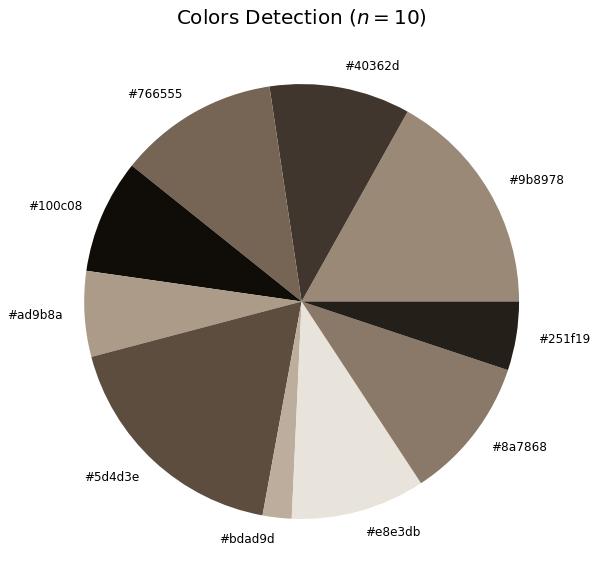

In [7]:
plt.title('Colors Detection ($n=10$)', fontsize=20)
plt.pie(counts.values(), labels = hex_colors, colors = hex_colors)

<h3>The Image Processing part</h3>
<p>So now we can see the colors and identify them, but can we associate each element of the 'label' list to its correspondent color, well lets go ahead identify...

<p> The main idea is pretty simple - the image is RGB encoded which means that if we compute the difference between the image and the RGB expression of one of the colors, we get [0,0,0] exactly when the image is equal to the color.

<h4>Converting RGB in integer values.</h4>

In [8]:
for i in range(len(rgb_colors)):
    rgb_colors[i] = rgb_colors[i].astype(int)

<h4>Break the image into smaller squares</h4>
<p>In this case, we've chosen the dimension of each square to be N_rows/10 X N_columns/10, thus obtaining 100 squares.</p>

In [9]:
def square_maker():
    inp_img = image
    h = int(inp_img.shape[0])
    step_h = int(h/10) 
    w = int(inp_img.shape[1])
    step_w = int(w/10) 
    X = np.arange(0,h+step_h,step_h)
    Y =np.arange(0,w+step_w,step_w)
    squares = [inp_img[0:step_h,0:step_w]]
    for i in range(0,len(X)-1):
        for j in range(0,len(Y)-1):
            squares.append(inp_img[X[i]:X[i+1],Y[j]:Y[j+1]])
    return np.array(squares)[1::]

<h4>We will pick the color that, in average, is closer to 0 than the others.</h4>

In [10]:
def color_computing(array):
    DIFF = []
    squared_image = square_maker()
    for square in squared_image:
        DIFF_COLOR = []
        for color in range(len(rgb_colors)):
            diff = np.abs(square - rgb_colors[color])
            DIFF_COLOR.append(diff.mean())
        DIFF.append(DIFF_COLOR)
    return np.array(DIFF)

<h4>Plot the "best color" for each square</h4>

In [11]:
def best_color_plot(selected_slice):
    plt.subplot(1,2,1)
    plt.title('Retrieved Color')
    plt.imshow((np.zeros((16,16,3))+ rgb_colors[color_computing(image)[selected_slice].argmin()]).astype(int))
    plt.subplot(1,2,2)
    plt.title('Selected Square: '+ str(selected_slice))
    plt.imshow(square_maker()[selected_slice])

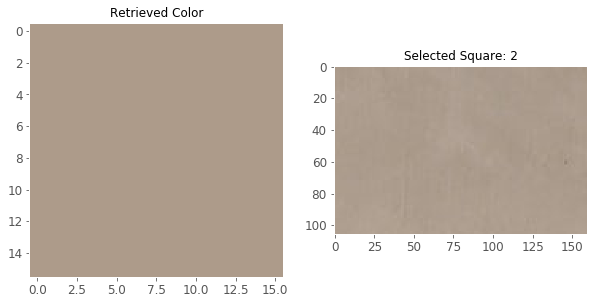

In [12]:
best_color_plot(2)

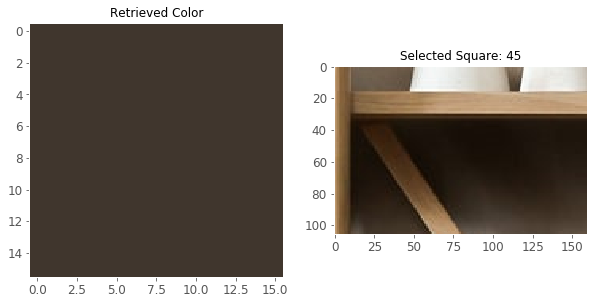

In [13]:
best_color_plot(45)

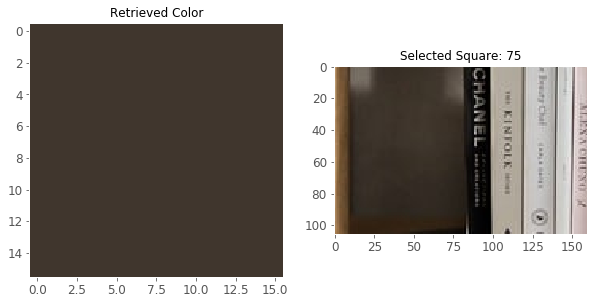

In [14]:
best_color_plot(75)

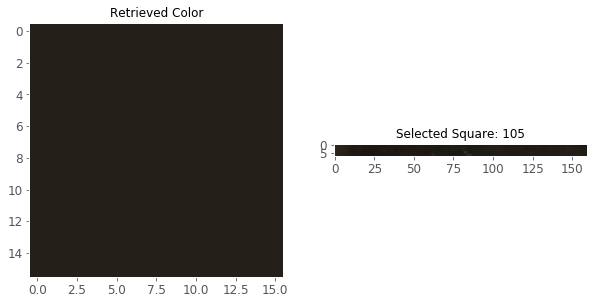

In [15]:
best_color_plot(105)

<h4>Summary of this example for all the squares of the image</h4>

In [16]:
def build_summary():
    results = color_computing(image)
    cols = ['Square Number'] + hex_colors
    sorted_results = pd.DataFrame(columns=cols)
    k=0
    
    for r in results:
        d = {'Square Number': int(k)}
        for c in range(len(hex_colors)):
            d[hex_colors[c]] = r[c]*100/r.sum()
        sorted_results = sorted_results.append(d, ignore_index=True)
        k = k+1
    sorted_results['Square Number'] = sorted_results['Square Number'].astype(int)
    return sorted_results

In [17]:
summary_df = build_summary()

In [18]:
summary_df.head()

,Square Number,#9b8978,#40362d,#766555,#100c08,#ad9b8a,#5d4d3e,#bdad9d,#e8e3db,#8a7868,#251f19
0,0,2.929640,15.721615,8.477967,22.246036,0.328832,12.176851,2.567313,10.735682,5.498310,19.317753
1,1,2.815962,15.689852,8.399818,22.256052,0.352771,12.122388,2.716191,10.936868,5.401081,19.309017
2,2,2.911586,15.712577,8.463658,22.241744,0.358411,12.165234,2.589657,10.763969,5.481834,19.311330
3,3,2.475839,15.571240,8.155772,22.250421,0.581089,11.942394,3.151503,11.513627,5.105437,19.252679
4,4,1.641804,15.253457,7.544492,22.196992,1.314530,11.480985,4.210311,12.903398,4.373429,19.080602


<p>The number under each column are the percentage of the color for that specific square.</p>

### Search Images Using Color
<p>Let's implement a search mechanism that can filter images based on the color supplied by us.</p>

#### Get All Images
<p> We first get all the images and store them in the <quote>images</quote> variable.</p>

In [50]:
import os

IMAGE_DIRECTORY = 'images'
COLORS = {
    'GREEN':[0, 128, 0],
    'YELLOW':[255, 255, 0],
    'BLUE':[0, 0, 128]
}

images = []

for file in os.listdir(IMAGE_DIRECTORY):
    if not file.startswith('.'):
        images.append(get_image(os.path.join(IMAGE_DIRECTORY, file)))

<p>The images are in the folder <quote><mark>images</mark></quote>. We define <quote><mark>COLORS</mark></quote> as a dictionary of colors. Then, we read all images in that folder and save their values in the <quote><mark>images</mark></quote> array.

#### Show All Images
<p>We first show all the images in the folder using the below mentioned <quote><mark>for</mark></quote> loop.

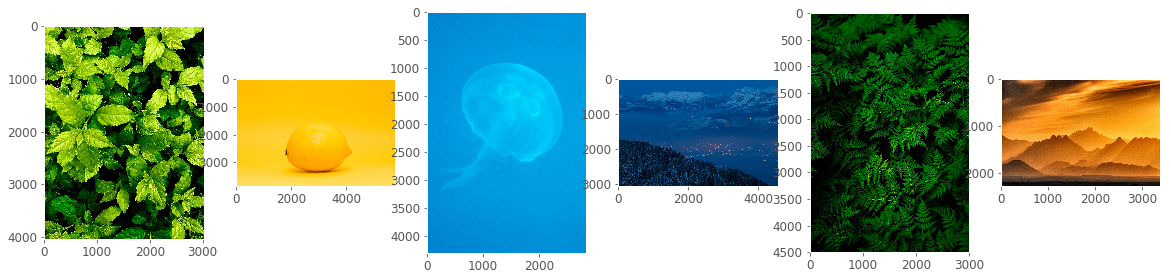

In [51]:
plt.figure(figsize=(20,10))
for i in range(len(images)):
    plt.subplot(1, len(images), i+1)
    plt.imshow(images[i])

#### Match Images With Color
<p>We will try to match with top 10 colors of the image. It is likely possible that there will be no extact match for the hex codes, thus we calculate the similarity between the chosen color and the colors of the image.</p>

<p>We keep a threshold value such that if the difference btw the chosen color and any of the selected colors is less than that threshold, we declare it as a match.</p>

<p>Hex values or RGB values cannot be directly compared so we first conver them to a device independent and color uniform space. We use <quote>rgb2lab</quote> to convert the values and then find the difference using <quote>deltaE_cie76</quote>. The method calculates the difference between all top 5 colors of the image and the selected color and if atleast one is below the threshold, we show the image</p>

In [52]:
def get_colors(image, number_of_colors, show_chart):
    
    modified_image = cv2.resize(image, (600, 400), interpolation = cv2.INTER_AREA)
    modified_image = modified_image.reshape(modified_image.shape[0]*modified_image.shape[1], 3)
    
    clf = KMeans(n_clusters = number_of_colors)
    labels = clf.fit_predict(modified_image)
    
    counts = Counter(labels)
    # sort to ensure correct color percentage
    counts = dict(sorted(counts.items()))
    
    center_colors = clf.cluster_centers_
    # We get ordered colors by iterating through the keys
    ordered_colors = [center_colors[i] for i in counts.keys()]
    hex_colors = [RGB2HEX(ordered_colors[i]) for i in counts.keys()]
    rgb_colors = [ordered_colors[i] for i in counts.keys()]

    if (show_chart):
        plt.figure(figsize = (8, 6))
        plt.pie(counts.values(), labels = hex_colors, colors = hex_colors)
    
    return rgb_colors

In [53]:
def match_image_by_color(image, color, threshold = 60, number_of_colors = 10): 
    
    image_colors = get_colors(image, number_of_colors, False)
    selected_color = rgb2lab(np.uint8(np.asarray([[color]])))

    select_image = False
    for i in range(number_of_colors):
        curr_color = rgb2lab(np.uint8(np.asarray([[image_colors[i]]])))
        diff = deltaE_cie76(selected_color, curr_color)
        if (diff < threshold):
            select_image = True
    
    return select_image

#### Show Selected Images
<p>We define a <quote><mark>show_selected_images</mark></quote> function that iterates over all images, calls the above function to filter them based on color, and displays them on the screen using <quote><mark>imshow</mark></quote>

In [54]:
def show_selected_images(images, color, threshold, colors_to_match):
    index = 1
    
    for i in range(len(images)):
        selected = match_image_by_color(images[i],
                                        color,
                                        threshold,
                                        colors_to_match)
        if (selected):
            plt.subplot(1, 5, index)
            plt.imshow(images[i])
            index += 1

#### Filter Results
<p>We will replace the variable <quote><mark>selected_color</mark></quote> with <quote><mark>COLORS['GREEN']</mark></quote> for Green, <quote><mark>COLORS['BLUE']</mark></quote> for Blue, <quote><mark>COLORS['YELLOW']</mark></quote> for Yellow. We set the threshold value to be <quote><mark>60</mark></quote> and total colors to be extracted from image to be <quote><mark>5</mark></quote>.

#### Search for Blue

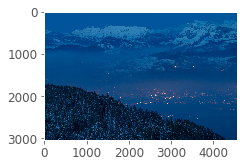

In [55]:
plt.figure(figsize = (20, 10))
show_selected_images(images, COLORS['BLUE'], 60, 5)

#### Search for Green

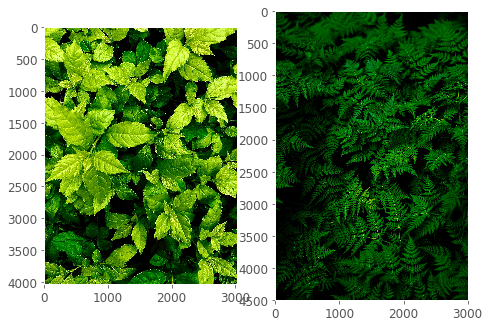

In [56]:
plt.figure(figsize = (20, 10))
show_selected_images(images, COLORS['GREEN'], 60, 5)

#### Search for Yellow

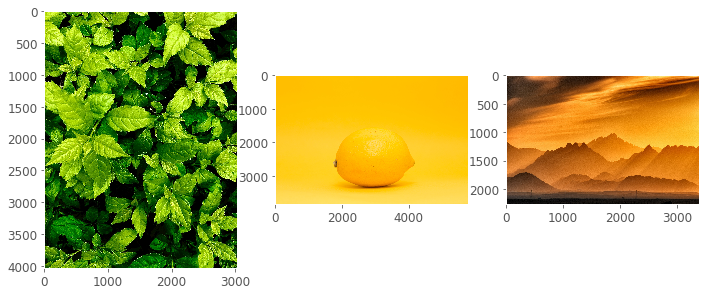

In [57]:
plt.figure(figsize = (20, 10))
show_selected_images(images, COLORS['YELLOW'], 60, 5)